# Group Selectivity PSTH Quick Plot

This notebook demonstrates the use of the `plot.group_psth` function to plot a group PSTH.

## Imports

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [15]:
%pylab --no-import-all
%matplotlib inline
import datajoint as dj

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [16]:
from pipeline import psth
from pipeline import plot
from pipeline import ephys

In [17]:
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)

In [18]:
Unit = ephys.Unit()
UnitPsth = psth.UnitPsth()
Selectivity = psth.Selectivity()
TrialCondition = psth.TrialCondition()

In [19]:
good_unit = Unit & {'unit_quality': 'good'}

In [20]:
good_unit

subject_id institution 6 digit animal ID,session session number,insertion_number,unit,unit_uid unique across sessions/animals,unit_quality,probe unique identifier for this model of probe (e.g. part number),electrode_config_id hash of the group and group_member (ensure uniqueness),electrode_group electrode group,electrode electrode,"unit_posx (um) estimated x position of the unit relative to probe's (0,0)","unit_posy (um) estimated y position of the unit relative to probe's (0,0)",spike_times (s) from the start of the first data point used in clustering,unit_amp,unit_snr,waveform average spike waveform
435884,1,1,1,1,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,6,42.4544792175293,33.699256896972656,=BLOB=,294.20157,13.780584,=BLOB=
435884,1,1,5,5,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,5,14.338550567626953,38.978546142578125,=BLOB=,157.83987,7.869556,=BLOB=
435884,1,1,10,10,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,10,44.27643966674805,79.20182800292969,=BLOB=,275.46558,13.48085,=BLOB=
435884,1,1,11,11,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,10,45.542633056640625,80.29844665527344,=BLOB=,117.8578,6.137078,=BLOB=
435884,1,1,15,15,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,12,31.08588409423828,98.89152526855469,=BLOB=,242.60864,14.416281,=BLOB=
435884,1,1,18,18,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,18,45.05342483520508,159.88873291015625,=BLOB=,142.01253,8.705505,=BLOB=
435884,1,1,21,21,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,22,46.288734436035156,199.1356201171875,=BLOB=,411.5883,19.068323,=BLOB=


In [21]:
conds_i = (TrialCondition
           & {'trial_condition_desc': 'good_noearlylick_left_hit'}).fetch('KEY')

conds_c = (TrialCondition
           & {'trial_condition_desc': 'good_noearlylick_right_hit'}).fetch('KEY')

In [22]:
sel_i = (ephys.Unit * psth.UnitSelectivity & 'unit_selectivity = "ipsi-selective"')
                    
sel_c = (ephys.Unit * psth.UnitSelectivity & 'unit_selectivity = "contra-selective"')

In [23]:
psth_i_i = (((UnitPsth & conds_i) * Unit.proj('unit_posx', 'unit_posy'))
            & good_unit.proj() & sel_i.proj()).fetch(order_by='unit_posy asc')

psth_i_c = (((UnitPsth & conds_c) * Unit.proj('unit_posx', 'unit_posy'))
            & good_unit.proj() & sel_i.proj()).fetch(order_by='unit_posy asc')

psth_c_c = (((UnitPsth & conds_c) * Unit.proj('unit_posx', 'unit_posy'))
            & good_unit.proj() & sel_c.proj()).fetch(order_by='unit_posy asc')

psth_c_i = (((UnitPsth & conds_i) * Unit.proj('unit_posx', 'unit_posy'))
            & good_unit.proj() & sel_c.proj()).fetch(order_by='unit_posy asc')

In [24]:
def movmean(data, nsamp=5):
    ret = np.cumsum(data, dtype=float)
    ret[nsamp:] = ret[nsamp:] - ret[:-nsamp]
    return ret[nsamp - 1:] / nsamp

In [25]:
def group_psth_ll(psth_a, psth_b, invert=False):
    plt_xmin, plt_xmax = -3, 3
    
    assert len(psth_a) == len(psth_b)
    nunits = len(psth_a)
    aspect = 2 / nunits
    extent = [plt_xmin, plt_xmax, 0, nunits]

    a_data = np.array([r[0] for r in psth_a['unit_psth']])
    b_data = np.array([r[0] for r in psth_b['unit_psth']])
    
    # scale per-unit psth's - TODO: moving average scaling
    a_data = np.array([movmean(i * (1 / np.max(i))) for i in a_data])
    b_data = np.array([movmean(i * (1 / np.max(i))) for i in b_data])
    
    if invert:
        result = (a_data - b_data) * -1
    else:
        result = a_data - b_data
    
    ax = plt.subplot(111)
    
    # ax.set_axis_off()
    ax.set_xlim([plt_xmin, plt_xmax])
    ax.axvline(0, 0, 1, ls='--', color='k')
    ax.axvline(-1.2, 0, 1, ls='--', color='k')
    ax.axvline(-2.4, 0, 1, ls='--', color='k')

    plt.imshow(result, cmap=plt.cm.bwr, aspect=aspect, extent=extent)

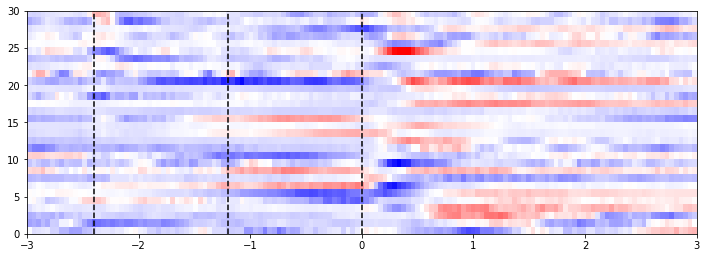

In [26]:
group_psth_ll(psth_i_i, psth_i_c)

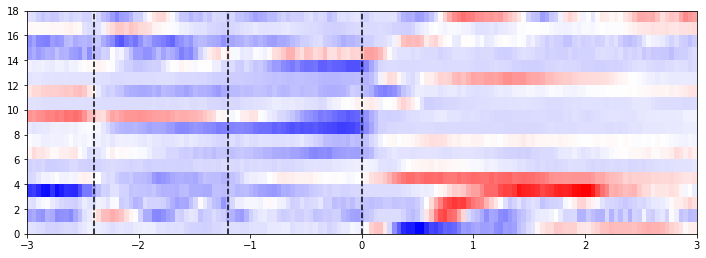

In [27]:
group_psth_ll(psth_c_i, psth_c_c, invert=True)